# Dependency

In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import tensorflow as tf
import torchvision
from torchvision.io import read_image
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Helper function

In [2]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("./AusRS/annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
    
# Calculate intersection out of union
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# Preprocessing

Convert XML file to yolo-formatted TXT file

In [3]:
# Get the annotations
annotations = [os.path.join('./AusRS/annotations', x) for x in os.listdir('./AusRS/annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('./AusRS/annotations', x) for x in os.listdir('./AusRS/annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:06<00:00, 141.21it/s]


Collect training set

In [4]:
train_images=[]
train_labels=[]

In [5]:
cv.setUseOptimized(True);
# instantiate selective search segmentation artifact
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
# collecting training set
for i in os.listdir('./AusRS/images/'):
    if i[-3:] == 'png':
        img = cv.imread(os.path.join('./AusRS/images/', i))
        print(os.path.join('./AusRS/images/', i))
        gtvalues=[]
        gtlabels = []
        
        # --- get ground truth bbox of training image ---
        im = Image.open(os.path.join('./AusRS/images/', i))
        with open(os.path.join('./AusRS/annotations/', i[:-3] + 'txt')) as f:
            lst = []
            for line in f:
                lst += [line.rstrip()]
        ann = []
        for i in lst[0].split(' '):
            ann.append(float(i))
        ann = [ann]

        class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

        annotations = np.array(ann)
        w, h = im.size

        transformed_annotations = np.copy(annotations)
        transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
        transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 

        transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
        transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
        transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
        transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

        for ann in transformed_annotations:
            obj_cls, x0, y0, x1, y1 = ann
            gtlabels.append(int(obj_cls))
            gtvalues.append({"x1":int(x0),"x2":int(x1),"y1":int(y0),"y2":int(y1)})
            
        # --- get segmented-proposed bbox ---

        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            # Assume first 2000 samples will contain target
            if e < 2000 and flag == 0:
                label_id = 0
                # for one image collect 30 positive samples and 30 negative samples
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70: # more than 70% means this bbox contains target
                            timage = imout[y:y+h,x:x+w]
                            resized = cv.resize(timage, (224,224), interpolation = cv.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(gtlabels[label_id])
                            label_id += 1
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3: # does not contain target
                            timage = imout[y:y+h,x:x+w]
                            resized = cv.resize(timage, (224,224), interpolation = cv.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(4)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1: # if contain target, print something
                    print("inside")
                    flag = 1

./AusRS/images/road0.png
./AusRS/images/road1.png
./AusRS/images/road10.png
./AusRS/images/road100.png
./AusRS/images/road101.png
./AusRS/images/road102.png
./AusRS/images/road103.png
inside
./AusRS/images/road104.png
inside
./AusRS/images/road105.png
inside
./AusRS/images/road106.png
./AusRS/images/road107.png
./AusRS/images/road108.png
./AusRS/images/road109.png
./AusRS/images/road11.png
./AusRS/images/road110.png
./AusRS/images/road111.png
./AusRS/images/road112.png
./AusRS/images/road113.png
./AusRS/images/road114.png
./AusRS/images/road115.png
./AusRS/images/road116.png
./AusRS/images/road117.png
./AusRS/images/road118.png
inside
./AusRS/images/road119.png
./AusRS/images/road12.png
./AusRS/images/road120.png
./AusRS/images/road121.png
./AusRS/images/road122.png
./AusRS/images/road123.png
inside
./AusRS/images/road124.png
./AusRS/images/road125.png
inside
./AusRS/images/road126.png
./AusRS/images/road127.png
./AusRS/images/road128.png
inside
./AusRS/images/road129.png
inside
./AusR

In [7]:
resized_train_images = []

In [8]:
for i in train_images:
    resized_train_images.append(cv.resize(i, (30, 30)))

In [9]:
train_images_np = np.array(resized_train_images)
train_labels_np = np.array(train_labels)

In [10]:
train_images_np.shape

(32697, 30, 30, 3)

In [21]:
cv.imshow('72.png', train_images_np[72])
cv.waitKey(0)
cv.destroyAllWindows()
print(train_labels[72])

0


# Splitting training & testing set

Using one-hot enconding to encode labels as this is multiple-class classification

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_images_np, train_labels_np, test_size=0.2)
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

# Model building

Using sequential and CNN package from keras framework

In [13]:
cnnModel = Sequential()
cnnModel.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
cnnModel.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnnModel.add(MaxPool2D(pool_size=(2, 2)))
cnnModel.add(Dropout(rate=0.25))
cnnModel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnnModel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnnModel.add(MaxPool2D(pool_size=(2, 2)))
cnnModel.add(Dropout(rate=0.25))
cnnModel.add(Flatten())
cnnModel.add(Dense(256, activation='relu'))
cnnModel.add(Dropout(rate=0.5))
cnnModel.add(Dense(5, activation='softmax'))

# Model compiling

In [14]:
epochs = 15
MSELoss = 'categorical_crossentropy'
AdamOptimizer = 'adam'
metric = ['accuracy']
cnnModel.compile(loss=MSELoss, optimizer=AdamOptimizer, metrics=metric)

# Model training

In [15]:
result = cnnModel.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
818/818 [==============================] - 15s 8ms/step - loss: 0.3369 - accuracy: 0.9258 - val_loss: 0.0827 - val_accuracy: 0.9783
Epoch 2/15
818/818 [==============================] - 6s 8ms/step - loss: 0.1200 - accuracy: 0.9657 - val_loss: 0.0611 - val_accuracy: 0.9826
Epoch 3/15
818/818 [==============================] - 6s 8ms/step - loss: 0.0902 - accuracy: 0.9752 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 4/15
818/818 [==============================] - 6s 8ms/step - loss: 0.0853 - accuracy: 0.9771 - val_loss: 0.0452 - val_accuracy: 0.9861
Epoch 5/15
818/818 [==============================] - 6s 8ms/step - loss: 0.0756 - accuracy: 0.9790 - val_loss: 0.0686 - val_accuracy: 0.9794
Epoch 6/15
818/818 [==============================] - 6s 8ms/step - loss: 0.0704 - accuracy: 0.9801 - val_loss: 0.0437 - val_accuracy: 0.9879
Epoch 7/15
818/818 [==============================] - 6s 8ms/step - loss: 0.1266 - accuracy: 0.9672 - val_loss: 0.0517 - val_accuracy: 0.9856
Epoch

# Model evaluation

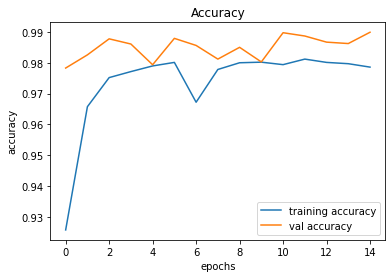

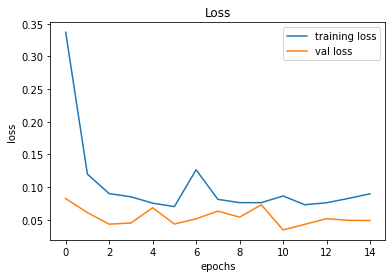

In [16]:
plt.figure(0)
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
cnnModel.save('RCNN_AusRS.h5')

In [18]:
pred = cnnModel.predict(X_test)

# --- convert one-hot predicted label back to normal form, calculate accuracy score
predLabel = []
ylabel = []

for item in pred:
    max = 0
    max_id = 0
    for i in range(0, len(item)):
        if item[i] >= max:
            max = item[i]
            max_id = i
    predLabel.append(max_id)
for item in y_test:
    max = 0
    max_id = 0
    for i in range(0, len(item)):
        if item[i] >= max:
            max = item[i]
            max_id = i
    ylabel.append(max_id)
    
print(accuracy_score(ylabel, predLabel))

205/205 [==============================] - 1s 3ms/step
0.9899082568807339


# Model visualization

In [19]:
map_dict = {0: 'trafficlight',
            1: 'stop',
            2: 'speedlimit',
            3: 'crosswalk'}

In [20]:
# Modify here
path = './AusRS/images/road875.png'
cnnModel = load_model('./RCNN_AusRS.h5')

img = cv.imread(path)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    # select first 1000 samples and use CNN net predict then (we assume first 1000 samples must contains target)
    if e < 1000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv.resize(timage, (30,30), interpolation = cv.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= cnnModel.predict(img)
        maxItem = 0
        maxItemId = 0
        for i in range(len(out[0])):
            if out[0][i] >= maxItem:
                maxItem = out[0][i]
                maxItemId = i
        print('Class pred: ' + str(maxItemId) + ' prob: ' + str(maxItem))
        if maxItemId != 4 and maxItem >= 0.95:
            cv.rectangle(imout, (x, y), (x+w, y+h), (0, 0, 255), 1, cv.LINE_AA)
            cv.putText(imout, map_dict[maxItemId], (x, y - 5), cv.FONT_HERSHEY_COMPLEX, 0.7, [0 , 0, 255], 2)

1/1 [==============================] - 0s 298ms/step
Class pred: 4 prob: 0.9999058
1/1 [==============================] - 0s 21ms/step
Class pred: 4 prob: 0.9994766
1/1 [==============================] - 0s 24ms/step
Class pred: 4 prob: 0.9999026
1/1 [==============================] - 0s 24ms/step
Class pred: 4 prob: 0.999689
1/1 [==============================] - 0s 23ms/step
Class pred: 4 prob: 0.99999976
1/1 [==============================] - 0s 25ms/step
Class pred: 4 prob: 0.9969528
1/1 [==============================] - 0s 24ms/step
Class pred: 4 prob: 0.9975592
1/1 [==============================] - 0s 25ms/step
Class pred: 4 prob: 0.99994326
1/1 [==============================] - 0s 22ms/step
Class pred: 4 prob: 0.99994516
1/1 [==============================] - 0s 21ms/step
Class pred: 4 prob: 0.9928207
1/1 [==============================] - 0s 23ms/step
Class pred: 4 prob: 0.9999881
1/1 [==============================] - 0s 23ms/step
Class pred: 4 prob: 0.9999051
1/1 [========

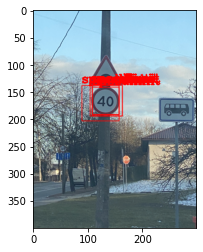

In [8]:
plt.imshow(cv.cvtColor(imout, cv.COLOR_BGR2RGB))